# SVG reading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import svglib
from svglib.svglib import svg2rlg
import io
from reportlab.graphics import renderPDF, renderPM
import PIL.Image
import reportlab

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, color, morphology
from skimage.segmentation import flood, flood_fill

In [3]:
from reportlab.graphics.shapes import *

class SVGExtractor:
    def __init__(self, drawing_path, scale=2):
        self.drawing_path = drawing_path
        self.scale = scale
        self.load_drawing()
    
    def load_drawing(self):
        self.drawing = svg2rlg("../resources/pen.svg")
        self.drawing.scale(self.scale, self.scale)
        self.drawing.width *= self.scale
        self.drawing.height *= self.scale

    def get_cls(self, svgclass, key=None, value=None):
        self.load_drawing()
        shape_group = self.drawing.contents[0]
        contents = shape_group.contents
        new_contents = []
        for shape in contents:
            if isinstance(shape, Group):
                obj = shape.contents[0]
                if isinstance(obj, svgclass):
                    if key:
                        if obj.__dict__[key] == value:
                            obj.__dict__[key] = 1.
                            new_contents.append(shape)
                    else:
                        new_contents.append(shape)
            elif isinstance(shape, svgclass):
                new_contents.append(shape)

        shape_group.contents = new_contents
        self.drawing.contents = [shape_group]
        return self.drawing
    
    def get_img(self):
        buffer = io.BytesIO()
        renderPM.drawToFile(self.drawing, buffer, fmt="PNG")
        img = PIL.Image.open(buffer)
        return img
    
    def show(self):
        plt.figure(figsize=(10,10))
        plt.imshow(self.get_img())


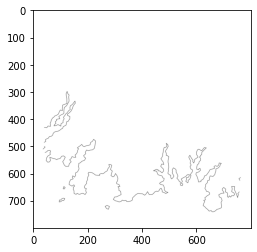

In [4]:
extractor = SVGExtractor("../resources/pen.svg")
drawing = extractor.get_cls(Path, "strokeWidth", 4.0)
buffer = io.BytesIO()
renderPM.drawToFile(drawing, buffer, fmt="PNG")
img = PIL.Image.open(buffer)
plt.imshow(img)

In [5]:
white = None

def get_city_coordinates(drawing, padding=10, alpha=1.57):
    global white
    centers = []
    for circle in drawing.contents[0].contents:
        white = circle.fillColor
        centers.append((
            int(circle.cy/alpha+drawing.height//2)-padding,
            int(circle.cx/alpha+drawing.width//2)-padding 
        ))
    return centers

# get city coordinates
extractor = SVGExtractor("../resources/pen.svg")
drawing = extractor.get_cls(Circle)
city_centers = get_city_coordinates(drawing)
city_centers

[(421, 267),
 (470, 575),
 (280, 312),
 (311, 564),
 (567, 320),
 (307, 174),
 (220, 601),
 (402, 615),
 (205, 393),
 (461, 464),
 (623, 157),
 (155, 236)]

In [6]:
from reportlab.lib import colors

def get_island_coordinates(drawing, padding=10, alpha=1.57):
    centers = []
    for group in drawing.contents[0].contents:
        points = group.contents[0].points
        if points[0]==points[-2] and points[1]==points[-1]:
            mx, my = 0, 0
            n_points = len(points[:-2])
            n_points = 2
            for i in range(0,n_points,2):
                mx += points[i]
                my += points[i+1]
            mx /= n_points
            my /= n_points
            centers.append((
                int(my*alpha+drawing.height//2)-padding,
                int(mx*alpha+drawing.width//2)-padding
            ))
    return centers

# def fill_islands(drawing):
#     for group in drawing.contents[0].contents:
#         points = group.contents[0].points
#         if points[0]==points[-2] and points[1]==points[-1]:
#             group.contents[0].fillMode=1
#             group.contents[0].fillColor=colors.black
#     return drawing        
            
extractor = SVGExtractor("../resources/pen.svg")
drawing = extractor.get_cls(Path, "strokeWidth", 4.0)
# drawing = fill_islands(drawing)
island_centers = get_island_coordinates(drawing)
# buffer = io.BytesIO()
# renderPM.drawToFile(drawing, buffer, fmt="PNG")
# img = PIL.Image.open(buffer)
# plt.imshow(img)

In [7]:
# drawing = extractor.get_cls(Circle)
# def circle_info(drawing, padding=10, alpha=1.57):
#     global white
#     centers = []
#     for circle in drawing.contents[0].contents:
#         print(circle.__dict__)
# circle_info(drawing)

In [8]:
# def fill_islands(drawing, color):
#     ngroup = []
#     for group in drawing.contents[0].contents:
#         points = group.contents[0].points
#         if points[0]==points[-2] and points[1]==points[-1]:
#             group.contents[0]._fillRule=0
#             group.contents[0].fillColor=color
#             group.contents[0].fillOpacity=1.0
#             ngroup.append(group)
#     drawing.contents[0].contents = ngroup
#     return drawing

# extractor = SVGExtractor("../resources/pen.svg")
# drawing = extractor.get_cls(Path, "strokeWidth", 4.0)
# drawing = fill_islands(drawing, white)
# # island_centers = get_island_coordinates(drawing)
# buffer = io.BytesIO()
# renderPM.drawToFile(drawing, buffer, fmt="PNG")
# img = PIL.Image.open(buffer)
# plt.imshow(img)

(608, 71)
(656, 57)
(680, 228)


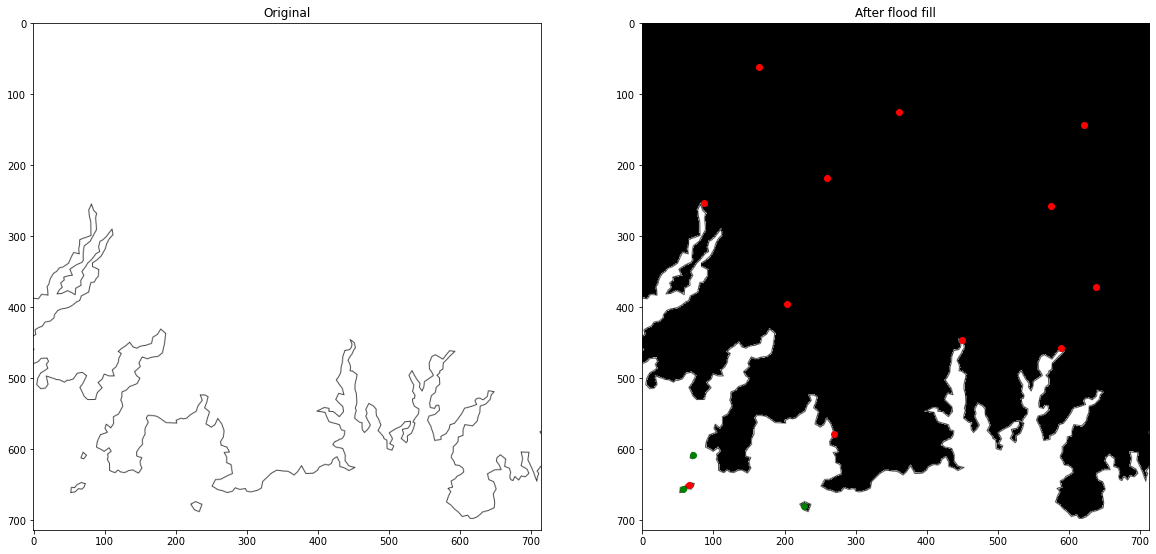

In [9]:
padding = 43
data = np.asarray(img)[padding:-padding,padding:-padding,0]

extractor = SVGExtractor("../resources/pen.svg")
drawing = extractor.get_cls(Circle)
city_centers = get_city_coordinates(drawing, padding=padding, alpha=1.25)

extractor = SVGExtractor("../resources/pen.svg")
drawing = extractor.get_cls(Path, "strokeWidth", 4.0)
island_centers = get_island_coordinates(drawing, padding=padding, alpha=1.575)

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].imshow(data, cmap=plt.cm.gray)
ax[0].set_title('Original')

for center in city_centers:
    try:
        data = flood_fill(data, center, 0)
        ax[1].plot(center[1], center[0], 'ro')  # seed point
    except IndexError:
        pass
for center in island_centers:
    try:
        data = flood_fill(data, center, 0)
        ax[1].plot(center[1], center[0], 'go')  # seed point
        print(center)
    except IndexError:
        pass

ax[1].imshow(data, cmap=plt.cm.gray)
ax[1].set_title('After flood fill')

plt.show()

# rivers

In [10]:
extractor = SVGExtractor("../resources/pen.svg")
drawing = extractor.get_cls(Path, "strokeWidth", 2.0)
# drawing.contents[0].contents[0].strokeWidth=6 # implement this instead of gaussian filter
rivers = np.asarray(extractor.get_img())[padding:-padding,padding:-padding,0]

# script

array([  0, 255])

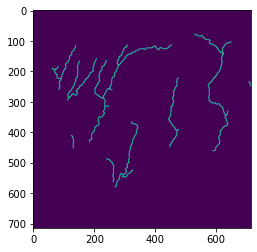

In [11]:
plt.imshow((rivers<255)*255)
np.unique((rivers<255)*255)

In [12]:
filled_checkers = (data-255)*255-(rivers<255)*255
filled_checkers = (filled_checkers > 254) * 255
np.unique(filled_checkers)

array([  0, 255])

In [13]:
import sys
sys.path.append('../terrain-erosion-3-ways/')
from river_network import *
import png

In [14]:
dim = int(drawing.height)-padding*2
shape = (dim,) * 2
disc_radius = 1.0
max_delta = 0.04
river_downcutting_constant = 1.3
directional_inertia = 0.4
default_water_level = 1.0
evaporation_rate = 0.2

print ('Generating...')

print('  ...initial terrain shape')
land_mask = remove_lakes(
  (util.fbm(shape, -2, lower=2.0) + bump(shape, 0.2 * dim) - 1.1) > 0)
land_mask = filled_checkers > 0
coastal_dropoff = np.tanh(util.dist_to_mask(land_mask) / 80.0) * land_mask
mountain_shapes = util.fbm(shape, -2, lower=2.0, upper=np.inf)
initial_height = ( 
  (util.gaussian_blur(np.maximum(mountain_shapes - 0.40, 0.0), sigma=5.0) 
    + 0.1) * coastal_dropoff)
deltas = util.normalize(np.abs(util.gaussian_gradient(initial_height))) 

print('  ...sampling points')
points = util.poisson_disc_sampling(shape, disc_radius)
coords = np.floor(points).astype(int)

Generating...
  ...initial terrain shape
  ...sampling points


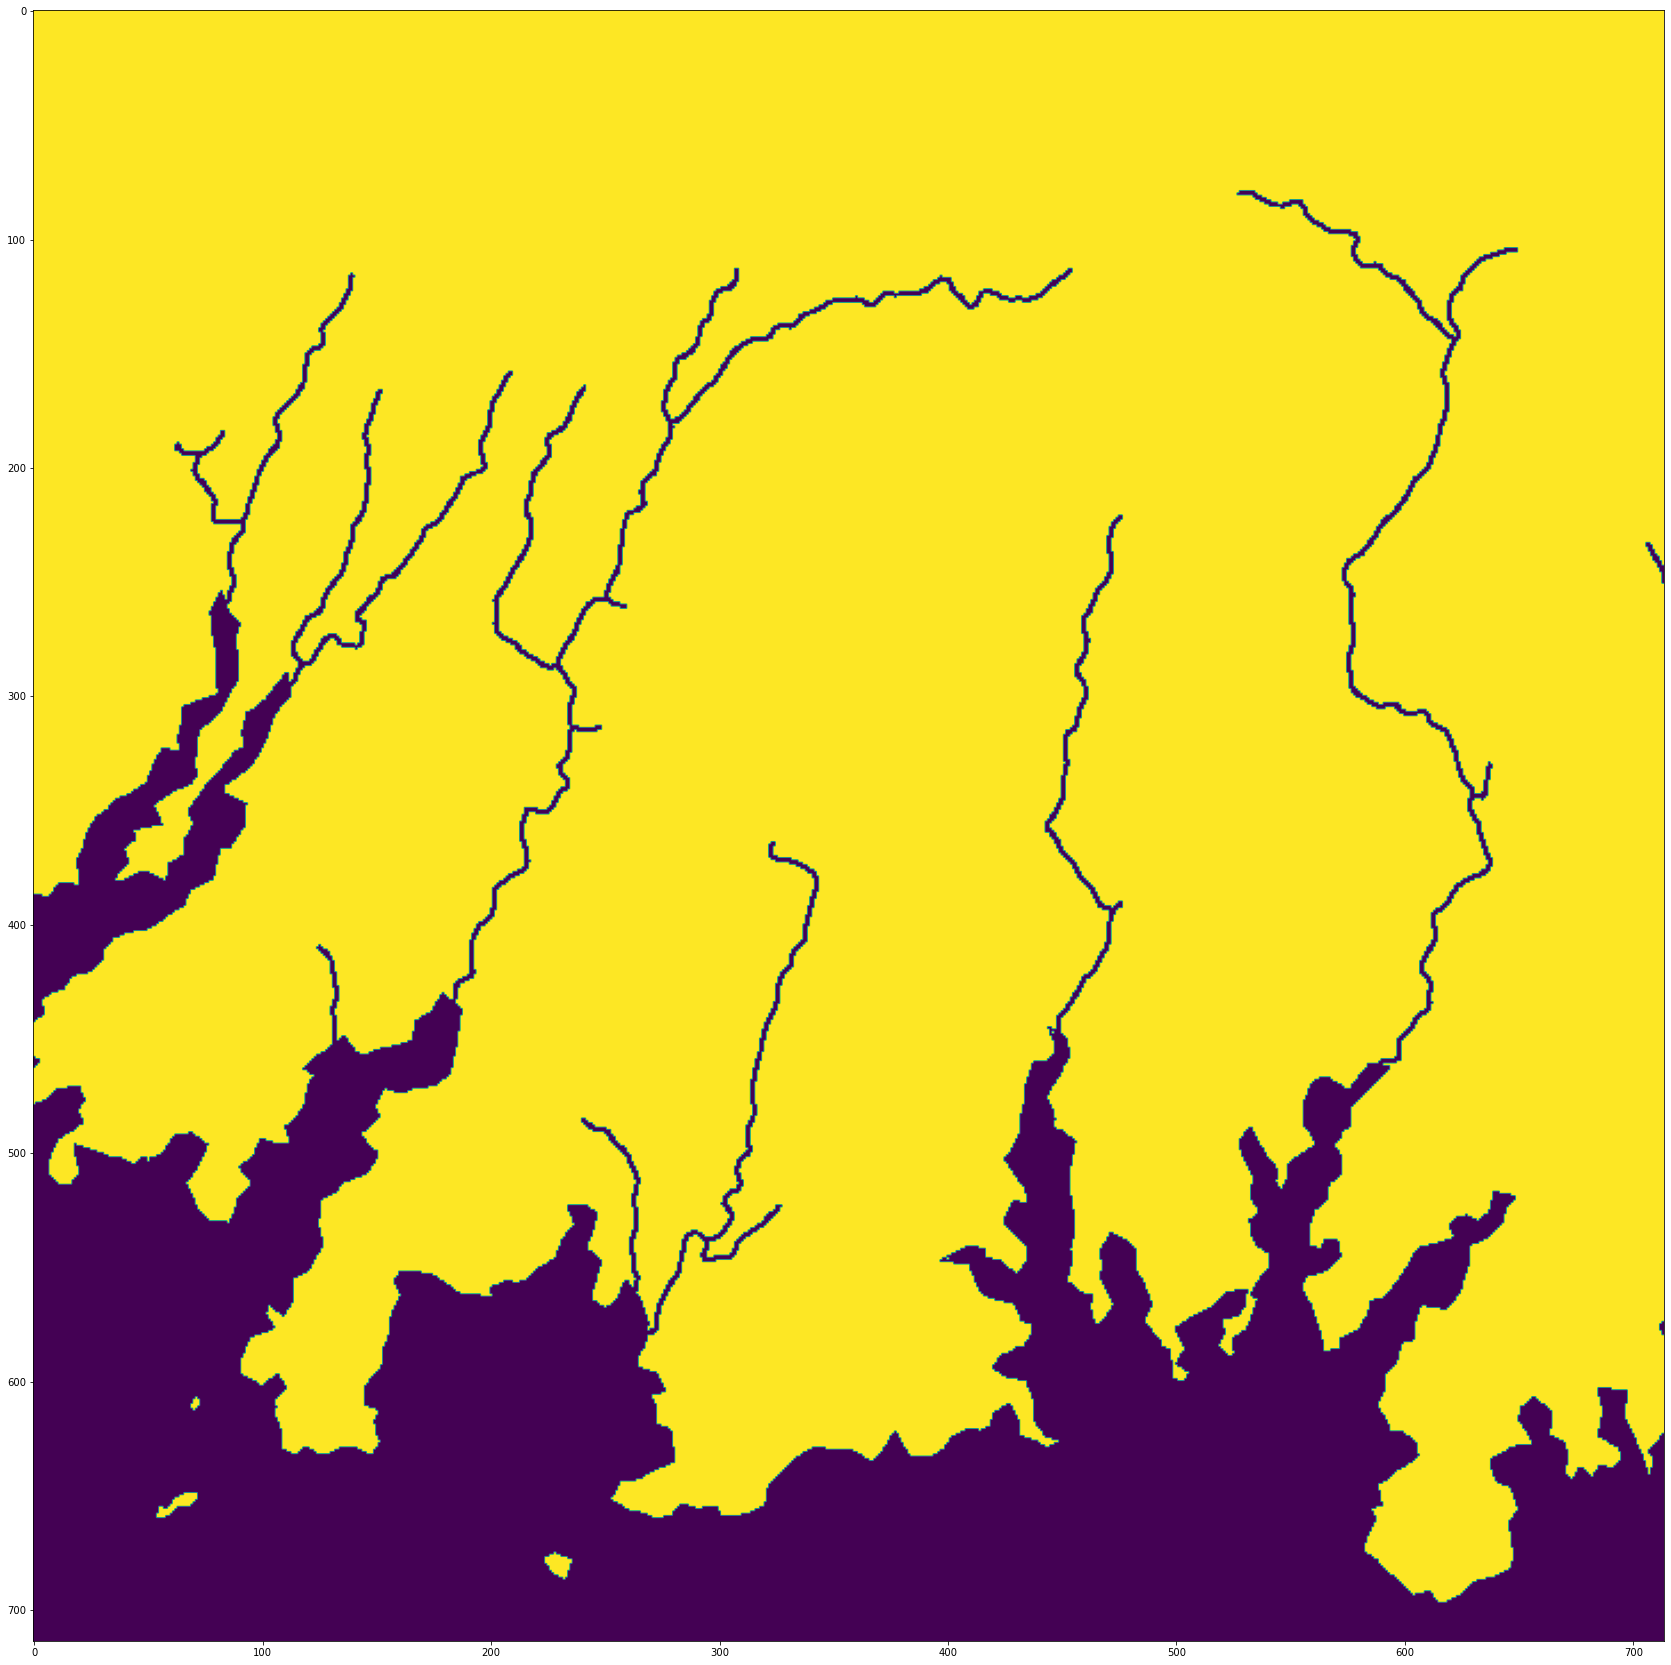

In [15]:
plt.figure(figsize=(30,30))
plt.imshow(land_mask)

In [16]:
print('  ...delaunay triangulation')
tri = sp.spatial.Delaunay(points)
(indices, indptr) = tri.vertex_neighbor_vertices
neighbors = [indptr[indices[k]:indices[k + 1]] for k in range(len(points))]
points_land = land_mask[coords[:, 0], coords[:, 1]]
points_deltas = deltas[coords[:, 0], coords[:, 1]]

print('  ...initial height map')
points_height = compute_height(points, neighbors, points_deltas)

print('  ...river network')
(upstream, downstream, volume) = compute_river_network(
  points, neighbors, points_height, points_land,
  directional_inertia, default_water_level, evaporation_rate)

print('  ...final terrain height')
new_height = compute_final_height(
  points, neighbors, points_deltas, volume, upstream, 
  max_delta, river_downcutting_constant)
terrain_height = render_triangulation(shape, tri, new_height)


  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


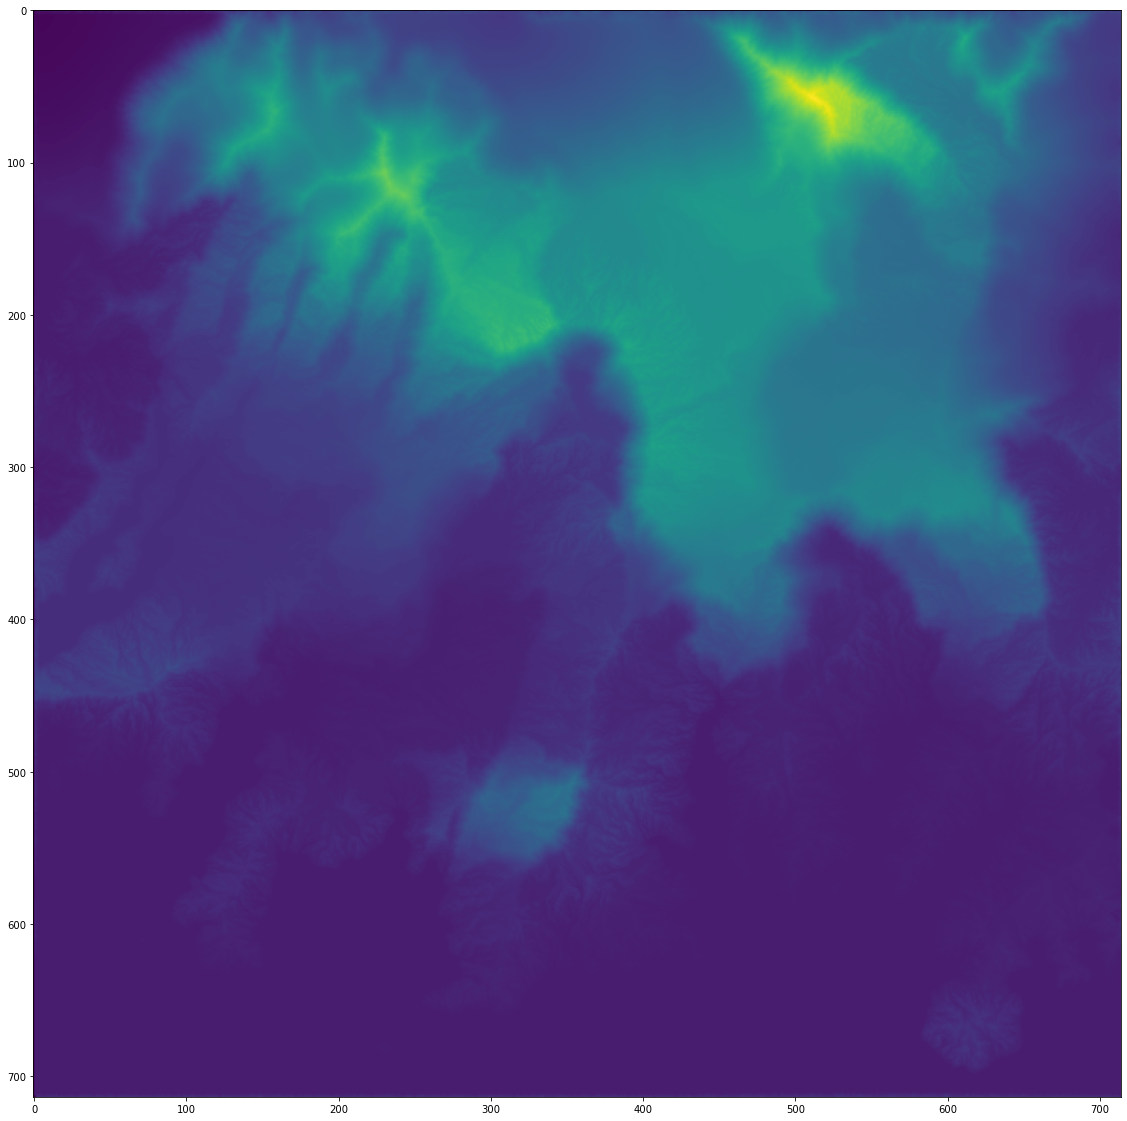

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(terrain_height)

In [18]:
qmap = (terrain_height*255).astype(np.uint8)

In [19]:
qimg = PIL.Image.fromarray(qmap).convert('L')
qimg.save("../output/test_total.png")